In [2]:
import os
import requests

video_path = "data/example/input_video.mp4"
model = "yolo"
interesting_frames = [212, 400, 460]

images_for_paper_path = "data/example/images_for_paper"

In [3]:
# Test if service is running
# response = requests.get("http://localhost:4321/")
# print(response.json())

In [4]:
def make_post_request(endpoint: str, body: dict) -> dict:
    response = requests.post(f"http://localhost:4321/{endpoint}", json=body)
    if response.status_code != 200:
        msg = f"Request failed with status code {response.status_code}: {response.text}"
        raise Exception(msg)
    return response.json()

In [5]:
# Track players
tracking_results_path = "data/example/predictions/tracking_results"
# tracking_results = make_post_request(
#     endpoint="track", 
#     body = {
#         "video_path": video_path,
#         "model": model,
#         "results_path": tracking_results_path
#     }
# )

In [6]:
# Load the detections file
import json
with open(os.path.join(tracking_results_path, "detections.json"), "r") as f:
    detections = json.load(f)

In [7]:
# Load the video and extract the interesting frames
import cv2
import numpy as np
import os

# Load the video
cap = cv2.VideoCapture(video_path)

# Create output directory if it doesn't exist
os.makedirs(images_for_paper_path, exist_ok=True)

# Process each interesting frame
for interesting_frame in interesting_frames:
    # Set the frame position to the interesting frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, interesting_frame)
    
    # Read the frame
    ret, frame = cap.read()
    if not ret:
        raise Exception(f"Could not read frame {interesting_frame}")
    
    # Get detections for this specific frame
    frame_detections = next((item for item in detections if item["frame_id"] == interesting_frame), None)
    
    if frame_detections is None:
        print(f"No detections found for frame {interesting_frame}")
        continue
    
    # Create a copy of the frame to draw on
    annotated_frame = frame.copy()
    
    # Draw bounding boxes and IDs
    for detection in frame_detections["detections"]:
        # Extract bbox coordinates
        bbox = detection["bbox"]
        x1, y1, x2, y2 = bbox["x1"], bbox["y1"], bbox["x2"], bbox["y2"]
        track_id = detection["track_id"]
        
        # Draw bright green bbox
        color = (0, 255, 0)  # Bright green in BGR
        thickness = 2
        cv2.rectangle(annotated_frame, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
        
        # Add track ID text
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(annotated_frame, f"{track_id}", (int(x1), int(y1) - 10), 
                    font, 0.7, color, 2)
        
        # Draw a black circle at the player's feet (bottom center of bounding box)
        feet_x = int((x1 + x2) / 2)  # Center x-coordinate
        feet_y = int(y2)  # Bottom y-coordinate
        circle_color = (0, 0, 0)  # Black in BGR
        circle_radius = 12
        circle_thickness = -1  # Filled circle
        cv2.circle(annotated_frame, (feet_x, feet_y), circle_radius, circle_color, circle_thickness)
    
    # Save the annotated frame as a PNG image
    output_path = f"{images_for_paper_path}/tracking_frame_{interesting_frame}.png"
    cv2.imwrite(output_path, annotated_frame)
    
    print(f"Saved annotated frame {interesting_frame} to {output_path}")

# Release the video capture
cap.release()

Saved annotated frame 212 to data/example/images_for_paper/tracking_frame_212.png
Saved annotated frame 400 to data/example/images_for_paper/tracking_frame_400.png
Saved annotated frame 460 to data/example/images_for_paper/tracking_frame_460.png


In [8]:
# Perspective transformation
transform_coordinates_results_path = "data/example/predictions/coordinate_transformation"
# transform_coordinates_results = make_post_request(
#     endpoint="transform-coordinates", 
#     body = {
#         "video_path": video_path,
#         "detections": detections,
#         "results_path": transform_coordinates_results_path
#     }
# )

In [9]:
# Load the detections file
import json
with open(os.path.join(transform_coordinates_results_path, "detections.json"), "r") as f:
    detections = json.load(f)
    
warped_image_paths = [f"data/example/predictions/coordinate_transformation/warped_images/frame_{interesting_frame:06d}.jpg" for interesting_frame in interesting_frames]

In [10]:
# Load the warped images and the pitch background
pitch_background = cv2.imread("src/utils/pitch_2.png")

if pitch_background is None:
    print(f"Error: Could not load pitch background from pitch_2.png")
else:
    # Get pitch background dimensions
    pitch_height, pitch_width = pitch_background.shape[:2]
    
    for i, warped_image_path in enumerate(warped_image_paths):
        warped_image = cv2.imread(warped_image_path)
        
        if warped_image is None:
            print(f"Error: Could not load warped image from {warped_image_path}")
            continue
            
        # Resize warped image to match pitch background dimensions
        resized_warped_image = cv2.resize(warped_image, (pitch_width, pitch_height))
        
        # Create a semi-transparent overlay
        alpha = 0.6  # Transparency factor (0.0 = fully transparent, 1.0 = fully opaque)
        overlay = pitch_background.copy()
        
        # Overlay the warped image on the pitch background
        cv2.addWeighted(resized_warped_image, alpha, pitch_background, 1 - alpha, 0, overlay)
        
        # Create a copy for annotation
        annotated_image = overlay.copy()
        
        # Find the detections for the current interesting frame
        current_frame = interesting_frames[i]
        frame_detections = None
        for frame_data in detections:
            if frame_data["frame_id"] == current_frame:
                frame_detections = frame_data["detections"]
                break
        
        if frame_detections:
            # Draw black dots at player positions
            for detection in frame_detections:
                if "minimap_coordinates" in detection and detection["minimap_coordinates"]:
                    coords = detection["minimap_coordinates"]
                    
                    # Rescale coordinates using x_max and y_max to match pitch dimensions
                    x_max = coords["x_max"]
                    y_max = coords["y_max"]
                    x_scaled = int((coords["x"] / x_max) * pitch_width)
                    y_scaled = int((coords["y"] / y_max) * pitch_height)
                    
                    # Draw a filled black circle (dot)
                    cv2.circle(annotated_image, (x_scaled, y_scaled), 10, (0, 0, 0), -1)  # -1 means filled circle
                    
        # Save the annotated image
        warped_output_path = f"{images_for_paper_path}/warped_tracking_{current_frame:06d}.png"
        cv2.imwrite(warped_output_path, annotated_image)
        print(f"Saved annotated warped image to {warped_output_path}")


Error: Could not load warped image from data/example/predictions/coordinate_transformation/warped_images/frame_000212.jpg
Error: Could not load warped image from data/example/predictions/coordinate_transformation/warped_images/frame_000400.jpg
Error: Could not load warped image from data/example/predictions/coordinate_transformation/warped_images/frame_000460.jpg


[ WARN:0@0.634] global loadsave.cpp:268 findDecoder imread_('data/example/predictions/coordinate_transformation/warped_images/frame_000212.jpg'): can't open/read file: check file path/integrity
[ WARN:0@0.635] global loadsave.cpp:268 findDecoder imread_('data/example/predictions/coordinate_transformation/warped_images/frame_000400.jpg'): can't open/read file: check file path/integrity
[ WARN:0@0.635] global loadsave.cpp:268 findDecoder imread_('data/example/predictions/coordinate_transformation/warped_images/frame_000460.jpg'): can't open/read file: check file path/integrity


In [11]:
# Assign colors to players
color_assignment_results_path = "data/example/predictions/color_assignment"
# color_assignment_results = make_post_request(
#     endpoint="assign-colors", 
#     body = {
#         "video_path": video_path,
#         "detections": detections,
#         "results_path": color_assignment_results_path
#     }
# )

In [12]:
with open(os.path.join(color_assignment_results_path, "detections.json"), "r") as f:
    detections = json.load(f)

In [13]:
# Assign roles
role_assignment_results_path = "data/example/predictions/role_assignment"
# role_assignment_results = make_post_request(
#     endpoint="assign-roles", 
#     body = {
#         "video_path": video_path,
#         "detections": detections,
#         "results_path": role_assignment_results_path
#     }
# )

In [14]:
with open(os.path.join(role_assignment_results_path, "detections.json"), "r") as f:
    detections = json.load(f)

In [15]:
# Visualize players on the pitch with team jersey colors and roles for all interesting frames
import numpy as np

# Load the soccer pitch
pitch_img_original = cv2.imread("src/utils/pitch_2.png")

# Get pitch dimensions
pitch_height, pitch_width, _ = pitch_img_original.shape

# Scale up the pitch image by a factor of 4
pitch_img_original = cv2.resize(pitch_img_original, (pitch_width * 4, pitch_height * 4))

# Get updated pitch dimensions after scaling
pitch_height, pitch_width, _ = pitch_img_original.shape

# Get frame dimensions from the video
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise Exception("Could not read frame")
frame_height, frame_width = frame.shape[:2]
cap.release()

# Define colors for different roles (in BGR format for OpenCV)
role_colors = {
    "TEAM A": (255, 255, 255),  # white
    "TEAM B": (0, 0, 255),      # red
    "REF": (0, 255, 255),       # yellow
    "GK": (0, 0, 0)             # black
}

# Process each interesting frame
for interesting_frame in interesting_frames:
    # Create a fresh copy of the pitch for each frame
    pitch_img = pitch_img_original.copy()
    
    # Get the frame with detections
    frame_detections = next((item for item in detections if item["frame_id"] == interesting_frame), None)
    
    if frame_detections:
        for detection in frame_detections["detections"]:
            coords = detection["minimap_coordinates"]
            if coords is None:
                continue
            x = coords["x"]
            y = coords["y"]
            x_max = coords["x_max"]
            y_max = coords["y_max"]
            
            # Normalize to pitch dimensions (with scaling factor of 4 applied)
            norm_x = int(x / x_max * pitch_width)
            norm_y = int(y / y_max * pitch_height)
            
            # Get player role and determine color
            role = detection["role"] if "role" in detection else "UNKNOWN"
            color = role_colors.get(role, (255, 0, 0))  # default to blue
            
            # Draw player as a circle (increased radius to match the scaling)
            cv2.circle(pitch_img, (norm_x, norm_y), 60, color, -1)
    
    # Save the image
    minimap_output_path = f"{images_for_paper_path}/minimap_{interesting_frame:06d}.png"
    cv2.imwrite(minimap_output_path, pitch_img)
    print(f"Saved minimap visualization for frame {interesting_frame} to {minimap_output_path}")

Saved minimap visualization for frame 212 to data/example/images_for_paper/minimap_000212.png
Saved minimap visualization for frame 400 to data/example/images_for_paper/minimap_000400.png
Saved minimap visualization for frame 460 to data/example/images_for_paper/minimap_000460.png


In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cv2

# Dictionary to store cluster centers for each frame
frame_cluster_centers = {}

# Process each interesting frame
for interesting_frame in interesting_frames:
    # Get the frame with detections
    frame_detections = next((item for item in detections if item["frame_id"] == interesting_frame), None)
    
    if not frame_detections:
        continue
    
    # Extract player positions and team information
    player_positions = []
    player_teams = []
    
    for detection in frame_detections["detections"]:
        coords = detection["minimap_coordinates"]
        role = detection["role"] if "role" in detection else "UNKNOWN"
        
        # Skip if coordinates are None or if it's a referee
        if coords is None or role == "REF":
            continue
        
        x = coords["x"]
        y = coords["y"]
        x_max = coords["x_max"]
        y_max = coords["y_max"]
        
        # Normalize to pitch dimensions (in meters)
        norm_x = x / x_max * 105  # 105m is pitch width
        norm_y = y / y_max * 68   # 68m is pitch height
        
        player_positions.append([norm_x, norm_y])
        player_teams.append(1 if role == "TEAM A" else 2 if role == "TEAM B" else 0)

    # Convert to numpy arrays
    player_positions = np.array(player_positions)
    player_teams = np.array(player_teams)
    
    # Skip if no player positions
    if len(player_positions) == 0:
        continue
    
    # Run DBSCAN to identify clusters
    clustering = DBSCAN(eps=4, min_samples=2).fit(player_positions)
    
    # Get cluster labels
    labels = clustering.labels_
    
    # Number of clusters (excluding noise points with label -1)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Frame {interesting_frame}: Number of clusters found: {n_clusters}")
    
    # Load the saved minimap image
    minimap_output_path = f"{images_for_paper_path}/minimap_{interesting_frame:06d}.png"
    minimap_img = cv2.imread(minimap_output_path)
    
    # Store cluster centers for this frame
    frame_cluster_centers[interesting_frame] = []
    
    # For each cluster, draw a circle and the cluster center only if it contains players from both teams
    for cluster_id in range(n_clusters):
        # Get points and teams in this cluster
        cluster_mask = labels == cluster_id
        cluster_points = player_positions[cluster_mask]
        cluster_teams = player_teams[cluster_mask]
        
        # Check if cluster contains players from both teams
        unique_teams = np.unique(cluster_teams)
        if len(unique_teams) < 2:  # Skip if not both teams present
            continue
        
        # Calculate cluster center
        center_x, center_y = np.mean(cluster_points, axis=0)
        
        # Store the center coordinates (in meters)
        frame_cluster_centers[interesting_frame].append([center_x, center_y])
        
        # Convert center coordinates back to image pixels
        center_x_px = int(center_x / 105 * pitch_width)
        center_y_px = int(center_y / 68 * pitch_height)
        
        # Calculate the radius based on the spread of points in the cluster
        if len(cluster_points) > 1:
            # Calculate the average distance from points to center
            distances = np.sqrt(np.sum((cluster_points - np.array([center_x, center_y]))**2, axis=1))
            radius = int(np.max(distances) / 105 * pitch_width) + 80
            
            # Ensure minimum radius
            radius = max(radius, 20)
            
            # Draw circle around the cluster
            cv2.circle(minimap_img, 
                      (center_x_px, center_y_px), 
                      radius,
                      (0, 255, 0),  # Green color
                      8)  # Line thickness
        
        # Draw cluster center with green dot
        cv2.circle(minimap_img, (center_x_px, center_y_px), 20, (0, 255, 0), -1)  # Green dot
    
    # Save the image with clusters
    clusters_output_path = f"{images_for_paper_path}/minimap_decision_critical_zones_{interesting_frame:06d}.png"
    cv2.imwrite(clusters_output_path, minimap_img)
    print(f"Saved minimap with clusters for frame {interesting_frame} to {clusters_output_path}")


Frame 212: Number of clusters found: 6
Saved minimap with clusters for frame 212 to data/example/images_for_paper/minimap_decision_critical_zones_000212.png
Frame 400: Number of clusters found: 3
Saved minimap with clusters for frame 400 to data/example/images_for_paper/minimap_decision_critical_zones_000400.png
Frame 460: Number of clusters found: 2
Saved minimap with clusters for frame 460 to data/example/images_for_paper/minimap_decision_critical_zones_000460.png


In [17]:
import numpy as np
from scipy.stats import gamma
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def gamma_score(distance, alpha=5.05, theta=2.83):
    """Calculate the normalized gamma score for a given distance."""
    mode = (alpha - 1) * theta
    g_max = gamma.pdf(mode, alpha, scale=theta)
    return gamma.pdf(distance, alpha, scale=theta) / g_max

def create_heatmap(minimap_img, cluster_centers, referee_position=None, pitch_width=105, pitch_height=68):
    """Create a heatmap overlay based on gamma distribution scores using seaborn YlOrRd colormap."""
    height, width = minimap_img.shape[:2]
    
    # Create coordinate grids
    y_coords, x_coords = np.mgrid[0:height, 0:width]
    
    # Convert pixel coordinates to meters
    x_meters = x_coords * pitch_width / width
    y_meters = y_coords * pitch_height / height
    
    # Reshape cluster centers for broadcasting
    centers = np.array(cluster_centers)
    centers_x = centers[:, 0].reshape(-1, 1, 1)
    centers_y = centers[:, 1].reshape(-1, 1, 1)
    
    # Calculate distances to all centers at once
    distances = np.sqrt((x_meters - centers_x)**2 + (y_meters - centers_y)**2)

    heatmap = np.prod(gamma_score(distances), axis=0)
    
    # If referee position is provided, calculate and print their score
    if referee_position is not None:
        # Calculate distances from referee to all cluster centers
        ref_distances = np.sqrt(np.sum((centers - referee_position)**2, axis=1))
        # Calculate referee's score using the same gamma scoring
        ref_score = np.prod(gamma_score(ref_distances))
        ref_score_normalized = (ref_score - heatmap.min()) / (heatmap.max() - heatmap.min())
        print(f"Referee score for frame: {ref_score_normalized:.4f}")
    
    # Normalize heatmap values to 0-1 range
    heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # Apply YlOrRd colormap using matplotlib
    cmap = plt.cm.YlOrRd
    heatmap_colored = cmap(heatmap_normalized)
    
    # Convert from RGBA (0-1) to BGR (0-255) format for OpenCV
    heatmap_colored_bgr = (heatmap_colored[:, :, [2, 1, 0]] * 255).astype(np.uint8)
    
    # Overlay heatmap on top of minimap image
    result_img = cv2.addWeighted(minimap_img, 0.3, heatmap_colored_bgr, 0.7, 0)
    
    # Draw referee position if available
    if referee_position is not None:
        # Convert referee position from meters to pixels
        ref_x_px = int(referee_position[0] / pitch_width * width)
        ref_y_px = int(referee_position[1] / pitch_height * height)
        # Draw yellow dot for referee
        cv2.circle(result_img, (ref_x_px, ref_y_px), 60, (0, 255, 255), -1)  # Yellow dot
    
    return result_img

# Create color legend
def create_color_legend():
    # Create a figure with a single subplot and transparent background
    fig, ax = plt.subplots(figsize=(8, 1))
    fig.patch.set_alpha(0)  # Make figure background transparent
    ax.patch.set_alpha(0)   # Make axes background transparent
    
    # Create a gradient from 0 to 1
    gradient = np.linspace(0, 1, 256).reshape(1, -1)
    
    # Create the colorbar directly without showing the gradient
    norm = plt.Normalize(0, 1)
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=norm)
    sm.set_array([])
    
    # Add colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
    cbar.set_label('Score', fontsize=10)
    
    # Remove the gradient plot
    ax.set_visible(False)
    
    plt.tight_layout()
    
    # Save the legend with transparent background
    legend_path = f"{images_for_paper_path}/legend.png"
    plt.savefig(legend_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.close()
    print(f"Saved color legend to {legend_path}")

# Create the color legend
create_color_legend()

# Process each interesting frame
for interesting_frame in interesting_frames:
    minimap_path = f"{images_for_paper_path}/minimap_decision_critical_zones_{interesting_frame:06d}.png"
    minimap_img = cv2.imread(minimap_path)
    
    if minimap_img is None:
        print(f"Could not load minimap for frame {interesting_frame}")
        continue
    
    # Get cluster centers from the previous cell
    if interesting_frame not in frame_cluster_centers:
        print(f"No cluster centers found for frame {interesting_frame}")
        continue
        
    cluster_centers = frame_cluster_centers[interesting_frame]
    
    if not cluster_centers:
        print(f"No valid cluster centers found for frame {interesting_frame}")
        continue
    
    # Get referee position for this frame
    frame_detections = next((item for item in detections if item["frame_id"] == interesting_frame), None)
    referee_position = None
    if frame_detections:
        for detection in frame_detections["detections"]:
            if detection.get("role") == "REF" and detection.get("minimap_coordinates"):
                coords = detection["minimap_coordinates"]
                x = coords["x"]
                y = coords["y"]
                x_max = coords["x_max"]
                y_max = coords["y_max"]
                norm_x = x / x_max * 105
                norm_y = y / y_max * 68
                referee_position = np.array([norm_x, norm_y])
                break
        
    heatmap_img = create_heatmap(minimap_img, cluster_centers, referee_position)
    
    output_path = f"{images_for_paper_path}/minimap_heatmap_{interesting_frame:06d}.png"
    cv2.imwrite(output_path, heatmap_img)
    print(f"Saved heatmap for frame {interesting_frame} to {output_path}")

Saved color legend to data/example/images_for_paper/legend.png
Referee score for frame: 0.7174
Saved heatmap for frame 212 to data/example/images_for_paper/minimap_heatmap_000212.png
Referee score for frame: 0.9847
Saved heatmap for frame 400 to data/example/images_for_paper/minimap_heatmap_000400.png
Referee score for frame: 0.5958
Saved heatmap for frame 460 to data/example/images_for_paper/minimap_heatmap_000460.png


In [18]:
# Create a figure showing player duels (players from opposing teams within 3 meters)
# Initialize dictionary to store referee positions
referee_positions = {}

for interesting_frame in interesting_frames:
    # Get the frame with detections
    frame_detections = next((item for item in detections if item["frame_id"] == interesting_frame), None)
    
    if not frame_detections:
        continue
    
    # Extract player positions and team information
    player_positions = []
    player_teams = []
    referee_position = None  # Initialize referee position
    
    for detection in frame_detections["detections"]:
        coords = detection["minimap_coordinates"]
        role = detection["role"] if "role" in detection else "UNKNOWN"
        
        # Store referee position separately
        if role == "REF" and coords is not None:
            x = coords["x"]
            y = coords["y"]
            x_max = coords["x_max"]
            y_max = coords["y_max"]
            
            # Normalize to pitch dimensions (in meters)
            norm_x = x / x_max * 105  # 105m is pitch width
            norm_y = y / y_max * 68   # 68m is pitch height
            
            referee_position = np.array([norm_x, norm_y])
            # Store referee position in dictionary
            referee_positions[interesting_frame] = referee_position
            continue
            
        # Skip if coordinates are None
        if coords is None:
            continue
        
        # Determine team based on role
        team = 1 if role == "TEAM A" else 2 if role == "TEAM B" else 0
        
        x = coords["x"]
        y = coords["y"]
        x_max = coords["x_max"]
        y_max = coords["y_max"]
        
        # Normalize to pitch dimensions (in meters)
        norm_x = x / x_max * 105  # 105m is pitch width
        norm_y = y / y_max * 68   # 68m is pitch height
        
        player_positions.append([norm_x, norm_y])
        player_teams.append(team)
    
    # Convert to numpy arrays
    player_positions = np.array(player_positions)
    player_teams = np.array(player_teams)
    
    # Skip if no player positions
    if len(player_positions) < 2:
        continue
    
    # Load the saved minimap image
    minimap_output_path = f"{images_for_paper_path}/minimap_{interesting_frame:06d}.png"
    minimap_img = cv2.imread(minimap_output_path)
    
    # Find duels (players from opposing teams within 3 meters)
    duels = []
    for i in range(len(player_positions)):
        for j in range(i+1, len(player_positions)):
            # Check if players are from different teams
            if player_teams[i] != player_teams[j]:
                # Calculate distance between players
                dist = np.sqrt(np.sum((player_positions[i] - player_positions[j])**2))
                
                # If distance is less than 3 meters, it's a duel
                if dist < 3:
                    duels.append((i, j))
    
    # Draw duels on the minimap
    for i, j in duels:
        # Get positions of the two players
        pos1, pos2 = player_positions[i], player_positions[j]
        
        # Convert coordinates to image pixels
        x1_px = int(pos1[0] / 105 * pitch_width)
        y1_px = int(pos1[1] / 68 * pitch_height)
        x2_px = int(pos2[0] / 105 * pitch_width)
        y2_px = int(pos2[1] / 68 * pitch_height)
        
        # Draw a line connecting the two players
        cv2.line(minimap_img, 
                (x1_px, y1_px), 
                (x2_px, y2_px), 
                (0, 255, 0),  # Green color
                8)  # Line thickness
        
        # Draw dots for the players
        team1_color = (0, 255, 0)  # Green for team 1
        team2_color = (0, 255, 0)  # Green for team 2
        
        cv2.circle(minimap_img, (x1_px, y1_px), 20, 
                  team1_color if player_teams[i] == 1 else team2_color, -1)
        cv2.circle(minimap_img, (x2_px, y2_px), 20, 
                  team1_color if player_teams[j] == 1 else team2_color, -1)
    
    # Draw lines from referee to the two closest duels if referee is present
    if referee_position is not None and duels:
        # Convert referee position to image pixels
        ref_x_px = int(referee_position[0] / 105 * pitch_width)
        ref_y_px = int(referee_position[1] / 68 * pitch_height)
        
        # Draw referee position
        cv2.circle(minimap_img, (ref_x_px, ref_y_px), 20, (0, 255, 0), -1)  # Green dot for referee
        
        # Calculate distances from referee to all duels
        duel_distances = []
        
        for idx, (i, j) in enumerate(duels):
            # Calculate midpoint of the duel
            duel_midpoint = (player_positions[i] + player_positions[j]) / 2
            
            # Calculate distance from referee to duel midpoint
            dist = np.sqrt(np.sum((referee_position - duel_midpoint)**2))
            
            duel_distances.append((idx, dist))
        
        # Sort duels by distance to referee
        duel_distances.sort(key=lambda x: x[1])
        
        # Draw lines to the two closest duels if available
        for k in range(min(2, len(duel_distances))):
            closest_duel_idx = duel_distances[k][0]
            i, j = duels[closest_duel_idx]
            
            # Get midpoint of the duel
            duel_midpoint = (player_positions[i] + player_positions[j]) / 2
            
            # Convert midpoint to image pixels
            mid_x_px = int(duel_midpoint[0] / 105 * pitch_width)
            mid_y_px = int(duel_midpoint[1] / 68 * pitch_height)
            
            # Draw a line from referee to duel midpoint
            cv2.line(minimap_img, 
                    (ref_x_px, ref_y_px), 
                    (mid_x_px, mid_y_px), 
                    (0, 255, 0),  # Green color
                    8,  # Line thickness
                    cv2.LINE_AA)  # Anti-aliased line
            
            # Calculate angle between duel line and referee line
            duel_vector = player_positions[j] - player_positions[i]
            ref_to_duel_vector = duel_midpoint - referee_position
            
            # Calculate unit vectors
            duel_unit = duel_vector / np.linalg.norm(duel_vector)
            ref_unit = ref_to_duel_vector / np.linalg.norm(ref_to_duel_vector)
            
            # Calculate dot product and angle
            dot_product = np.dot(duel_unit, ref_unit)
            # Clip to handle floating point errors
            dot_product = np.clip(dot_product, -1.0, 1.0)
            angle_rad = np.arccos(dot_product)
            angle_deg = np.degrees(angle_rad)
            
            # Always get the acute angle (less than 90 degrees)
            if angle_deg > 90:
                angle_deg = 180 - angle_deg
                
            print(f"Frame {interesting_frame}: Angle between duel {k+1} and referee line: {angle_deg:.2f} degrees")
    
    # Save the image with duels
    duels_output_path = f"{images_for_paper_path}/minimap_duels_{interesting_frame:06d}.png"
    cv2.imwrite(duels_output_path, minimap_img)
    print(f"Frame {interesting_frame}: Number of duels found: {len(duels)}")
    print(f"Saved minimap with duels for frame {interesting_frame} to {duels_output_path}")


Frame 212: Angle between duel 1 and referee line: 65.84 degrees
Frame 212: Angle between duel 2 and referee line: 35.79 degrees
Frame 212: Number of duels found: 5
Saved minimap with duels for frame 212 to data/example/images_for_paper/minimap_duels_000212.png
Frame 400: Angle between duel 1 and referee line: 48.95 degrees
Frame 400: Angle between duel 2 and referee line: 62.97 degrees
Frame 400: Number of duels found: 2
Saved minimap with duels for frame 400 to data/example/images_for_paper/minimap_duels_000400.png
Frame 460: Number of duels found: 0
Saved minimap with duels for frame 460 to data/example/images_for_paper/minimap_duels_000460.png


/var/folders/6l/p6zt7z7j3qz18vr9n_6dpf3w0000gn/T/ipykernel_2845/2165280920.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center right')


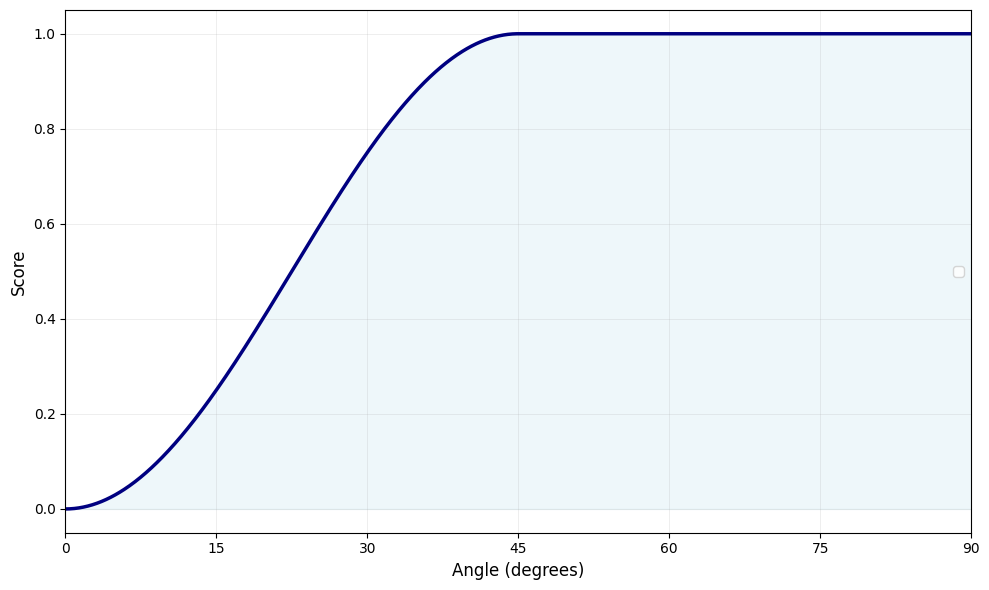

Cosine Transition Function Values:
f( 0.00°) = 0.000000
f(11.25°) = 0.146447
f(22.50°) = 0.500000
f(33.75°) = 0.853553
f(45.00°) = 1.000000
f(67.50°) = 1.000000
f(90.00°) = 1.000000

Function properties:
- Starts at exactly 0 when θ = 0°
- Reaches exactly 1 when θ = 45°
- Smooth cosine transition with natural acceleration/deceleration
- Constant at 1 for θ > 45°


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_score_function(angle):
    """
    Piecewise function using cosine transition from 0 to 1 between 0-45 degrees,
    then constant at 1 from 45-90 degrees.
    """
    score = np.zeros_like(angle)
    
    # For angles 0 to 45: cosine transition
    mask1 = angle <= 45
    t = angle[mask1] / 45  # Normalize to [0,1]
    score[mask1] = (1 - np.cos(np.pi * t)) / 2
    
    # For angles > 45: constant at 1
    mask2 = angle > 45
    score[mask2] = 1
    
    return score

# Generate data points
angles = np.linspace(0, 90, 1000)
scores = cosine_score_function(angles)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(angles, scores, 'navy', linewidth=2.5)
plt.fill_between(angles, scores, alpha=0.2, color='lightblue')

# Customize the plot
plt.xlabel('Angle (degrees)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xlim(0, 90)
plt.ylim(-0.05, 1.05)


# Customize ticks
plt.xticks(np.arange(0, 91, 15))
plt.yticks(np.arange(0, 1.1, 0.2))

# Add legend
plt.legend(loc='center right')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# Print function values at key points
print("Cosine Transition Function Values:")
print("=" * 40)
test_angles = [0, 11.25, 22.5, 33.75, 45, 67.5, 90]
for angle in test_angles:
    score = cosine_score_function(np.array([angle]))[0]
    print(f"f({angle:5.2f}°) = {score:.6f}")

print(f"\nFunction properties:")
print(f"- Starts at exactly 0 when θ = 0°")
print(f"- Reaches exactly 1 when θ = 45°") 
print(f"- Smooth cosine transition with natural acceleration/deceleration")
print(f"- Constant at 1 for θ > 45°")

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.cluster import DBSCAN

def cosine_score_function(angle):
    """
    Piecewise function using cosine transition from 0 to 1 between 0-45 degrees,
    then constant at 1 from 45-90 degrees.
    """
    score = np.zeros_like(angle)
    
    # For angles 0 to 45: cosine transition
    mask1 = angle <= 45
    t = angle[mask1] / 45  # Normalize to [0,1]
    score[mask1] = (1 - np.cos(np.pi * t)) / 2
    
    # For angles > 45: constant at 1
    mask2 = angle > 45
    score[mask2] = 1
    
    return score

def extract_duels_with_orientation_for_frame(frame_id, detections):
    """Extract duel positions and their orientations for a single frame"""
    frame_duels = []
    
    frame_detections = next((item for item in detections if item["frame_id"] == frame_id), None)
    if not frame_detections:
        return frame_duels
    
    # Extract player positions
    player_positions = []
    player_teams = []
    
    for detection in frame_detections["detections"]:
        coords = detection["minimap_coordinates"]
        role = detection["role"] if "role" in detection else "UNKNOWN"
        
        # Skip if coordinates are None or if it's a referee
        if coords is None or role == "REF":
            continue
        
        x = coords["x"]
        y = coords["y"]
        x_max = coords["x_max"]
        y_max = coords["y_max"]
        
        # Normalize to pitch dimensions (in meters)
        norm_x = x / x_max * 105  # 105m is pitch width
        norm_y = y / y_max * 68   # 68m is pitch height
        
        player_positions.append([norm_x, norm_y])
        player_teams.append(1 if role == "TEAM A" else 2 if role == "TEAM B" else 0)
    
    # Convert to numpy arrays
    player_positions = np.array(player_positions)
    player_teams = np.array(player_teams)
    
    # Find duels (players from opposing teams within 3 meters)
    if len(player_positions) >= 2:
        for i in range(len(player_positions)):
            for j in range(i+1, len(player_positions)):
                # Check if players are from different teams
                if player_teams[i] != player_teams[j]:
                    # Calculate distance between players
                    dist = np.sqrt(np.sum((player_positions[i] - player_positions[j])**2))
                    
                    # If distance is less than 3 meters, it's a duel
                    if dist < 3:
                        # Get midpoint and orientation of the duel
                        duel_center = (player_positions[i] + player_positions[j]) / 2
                        duel_vector = player_positions[j] - player_positions[i]
                        duel_angle = np.arctan2(duel_vector[1], duel_vector[0])
                        
                        frame_duels.append({
                            'center': duel_center,
                            'angle': duel_angle,
                            'players': [player_positions[i], player_positions[j]]
                        })
    
    return frame_duels

def create_angular_heatmap(duels, image_size=(105, 68), radius=15):
    """Create a heatmap showing angular scoring around each duel"""
    
    # Create coordinate grid with much higher resolution
    x = np.linspace(0, image_size[0], 2100)  # 20 points per meter
    y = np.linspace(0, image_size[1], 1360)  # 20 points per meter
    X, Y = np.meshgrid(x, y)
    
    # Initialize heatmap
    heatmap = np.ones_like(X)
    
    # For each duel position
    for duel in duels: ######## CHANGE THIS TO INCLUDE ONLY 1 DUEL
        duel_center = duel['center']
        duel_line_angle = duel['angle']
        
        # Calculate distances from duel center
        dx = X - duel_center[0]
        dy = Y - duel_center[1]
        
        # Calculate angles from duel center to each grid point
        point_angles = np.arctan2(dy, dx)
        
        # Calculate relative angles to the duel line
        relative_angles = np.abs(point_angles - duel_line_angle)

        # ensure angles are between 0 and 360 degrees
        relative_angles = np.mod(relative_angles, 2 * np.pi)

        # ensure between 0 and 180 degrees
        relative_angles = np.minimum(relative_angles, 2 * np.pi - relative_angles)

        # take the acute angle
        relative_angles = np.minimum(relative_angles, np.pi - relative_angles)

        relative_angles = np.degrees(relative_angles)
        
        # Apply cosine scoring function
        scores = cosine_score_function(relative_angles)
        
        # multiply to heatmap
        heatmap *= scores
    
    # Normalize heatmap to 0-1 range
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    return heatmap, x, y

def load_minimap_duels_background(frame_id):
    """Load the minimap_duels background image for a specific frame"""
    minimap_path = f"data/example/images_for_paper/minimap_duels_{frame_id:06d}.png"
    if os.path.exists(minimap_path):
        return cv2.imread(minimap_path)
    else:
        # Fallback to generic pitch if minimap not found
        pitch_path = 'src/utils/pitch_2.png'
        if os.path.exists(pitch_path):
            return cv2.imread(pitch_path)
        else:
            # Create a simple green background if no images found
            return np.zeros((680, 1050, 3), dtype=np.uint8) + [0, 128, 0]  # Green background

def evaluate_referee_position(frame_id, heatmap, x_coords, y_coords, referee_positions):
    """Evaluate referee position based on the heatmap"""
    if frame_id not in referee_positions:
        return None
    
    ref_pos = referee_positions[frame_id]
    # Convert referee position to heatmap coordinates
    ref_x = ref_pos[0] / 105 * (len(x_coords) - 1)
    ref_y = ref_pos[1] / 68 * (len(y_coords) - 1)
    
    # Get heatmap value at referee position
    ref_x_idx = int(ref_x)
    ref_y_idx = int(ref_y)
    
    if 0 <= ref_x_idx < len(x_coords) and 0 <= ref_y_idx < len(y_coords):
        score = heatmap[ref_y_idx, ref_x_idx]
        print(f"Referee position {ref_pos} has score {score}")
        return {
            'position': ref_pos,
            'score': score,
            'evaluation': 'Good' if score > 0.7 else 'Fair' if score > 0.4 else 'Poor'
        }
    return None

def save_angular_heatmap_for_frame(frame_id, duels, referee_positions, output_dir="data/example/images_for_paper"):
    """Create and save angular heatmap for a single frame with referee evaluation"""
    
    if len(duels) == 0:
        print(f"No duels found for frame {frame_id}")
        return
    
    # Create angular heatmap
    heatmap, x_coords, y_coords = create_angular_heatmap(duels, radius=20)
    
    # Evaluate referee position
    ref_evaluation = evaluate_referee_position(frame_id, heatmap, x_coords, y_coords, referee_positions)
    
    # Load minimap duels background for this frame
    background_image = load_minimap_duels_background(frame_id)
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Convert background image from BGR to RGB if needed
    if len(background_image.shape) == 3:
        background_rgb = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    else:
        background_rgb = background_image
    
    # Display background image
    ax.imshow(background_rgb, extent=[0, 105, 0, 68], alpha=0.8)
    
    # Overlay heatmap
    extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]
    im = ax.imshow(heatmap, cmap='YlOrRd', alpha=0.7, extent=extent)
    
    # Add referee position if available
    if ref_evaluation:
        ax.plot(ref_evaluation['position'][0], 68 - ref_evaluation['position'][1], 'yo', markersize=10, color='yellow')
        
    # Save the figure
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"minimap_duel_heatmap_{frame_id:06d}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Saved angular heatmap for frame {frame_id} with {len(duels)} duels to {output_path}")

# Process each frame separately
for frame_id in interesting_frames:
    duels = extract_duels_with_orientation_for_frame(frame_id, detections)
    save_angular_heatmap_for_frame(frame_id, duels, referee_positions)

print("Angular heatmap generation completed for all frames")

Referee position [48.6171875  43.76351351] has score 0.5991702157449248


/var/folders/6l/p6zt7z7j3qz18vr9n_6dpf3w0000gn/T/ipykernel_2845/2584997156.py:206: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  ax.plot(ref_evaluation['position'][0], 68 - ref_evaluation['position'][1], 'yo', markersize=10, color='yellow')


Saved angular heatmap for frame 212 with 5 duels to data/example/images_for_paper/minimap_duel_heatmap_000212.png
Referee position [21.984375   47.15202703] has score 1.0
Saved angular heatmap for frame 400 with 2 duels to data/example/images_for_paper/minimap_duel_heatmap_000400.png
No duels found for frame 460
Angular heatmap generation completed for all frames
